# Final

In [52]:
#%conda install wordcloud

In [54]:
#%pip install contractions

In [8]:
# data tools
import os
import re
import json 
import string
import warnings 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
warnings.filterwarnings('ignore')
from subprocess import check_output
import contractions

# nltk and sklearn
import nltk
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# tensorflow and keras
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import model_from_json
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding, LSTM, Conv1D, MaxPooling1D
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

In [10]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Get the dataset (Amazon Video Game Reviews)

In [11]:
#!curl https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Video_Games_v1_00.tsv.gz -o games.tsv.gz
#!gzip -d games.tsv.gz

# Load into Pandas DataFrame 

There are a small number of lines in this file that don't parse properly

In [12]:
games = pd.read_csv('games.tsv', delimiter = '\t', error_bad_lines=False)

b'Skipping line 20630: expected 15 fields, saw 22\nSkipping line 28172: expected 15 fields, saw 22\nSkipping line 54791: expected 15 fields, saw 22\n'
b'Skipping line 75419: expected 15 fields, saw 22\nSkipping line 104832: expected 15 fields, saw 22\n'
b'Skipping line 138464: expected 15 fields, saw 22\nSkipping line 194849: expected 15 fields, saw 22\n'
b'Skipping line 201568: expected 15 fields, saw 22\nSkipping line 242567: expected 15 fields, saw 22\n'
b'Skipping line 493585: expected 15 fields, saw 22\nSkipping line 502478: expected 15 fields, saw 22\n'
b'Skipping line 660750: expected 15 fields, saw 22\n'


# Examine Data

In [13]:
games.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,12039526,RTIS3L2M1F5SM,B001CXYMFS,737716809,Thrustmaster T-Flight Hotas X Flight Stick,Video Games,5,0,0,N,Y,an amazing joystick. I especially love that yo...,"Used this for Elite Dangerous on my mac, an am...",2015-08-31
1,US,9636577,R1ZV7R40OLHKD,B00M920ND6,569686175,Tonsee 6 buttons Wireless Optical Silent Gamin...,Video Games,5,0,0,N,Y,Definitely a silent mouse... Not a single clic...,"Loved it, I didn't even realise it was a gami...",2015-08-31
2,US,2331478,R3BH071QLH8QMC,B0029CSOD2,98937668,Hidden Mysteries: Titanic Secrets of the Fatef...,Video Games,1,0,1,N,Y,One Star,poor quality work and not as it is advertised.,2015-08-31
3,US,52495923,R127K9NTSXA2YH,B00GOOSV98,23143350,GelTabz Performance Thumb Grips - PlayStation ...,Video Games,3,0,0,N,Y,"good, but could be bettee","nice, but tend to slip away from stick in inte...",2015-08-31
4,US,14533949,R32ZWUXDJPW27Q,B00Y074JOM,821342511,Zero Suit Samus amiibo - Japan Import (Super S...,Video Games,4,0,0,N,Y,Great but flawed.,"Great amiibo, great for collecting. Quality ma...",2015-08-31


In [14]:
games.dtypes

marketplace          object
customer_id           int64
review_id            object
product_id           object
product_parent        int64
product_title        object
product_category     object
star_rating           int64
helpful_votes         int64
total_votes           int64
vine                 object
verified_purchase    object
review_headline      object
review_body          object
review_date          object
dtype: object

The data types all seem to be correct

In [15]:
games.describe()

,customer_id,product_parent,star_rating,helpful_votes,total_votes
count,1.780268e+06,1.780268e+06,1.780268e+06,1.780268e+06,1.780268e+06
mean,2.803021e+07,4.954251e+08,4.059375e+00,2.263971e+00,3.764128e+00
std,1.562851e+07,2.909145e+08,1.355964e+00,1.919211e+01,2.247177e+01
min,1.001800e+04,3.140000e+03,1.000000e+00,0.000000e+00,0.000000e+00
25%,1.429715e+07,2.452708e+08,4.000000e+00,0.000000e+00,0.000000e+00
50%,2.732141e+07,4.920909e+08,5.000000e+00,0.000000e+00,1.000000e+00
75%,4.274834e+07,7.485890e+08,5.000000e+00,1.000000e+00,3.000000e+00
max,5.309656e+07,9.999685e+08,5.000000e+00,1.049800e+04,1.078000e+04


In [16]:
games.star_rating.value_counts()

5    1023167
4     317460
1     191633
3     153451
2      94557
Name: star_rating, dtype: int64

Star ratings tend to be fairly high on average with a mean of 4, most reviews have no helpful_votes but some reviews have a lot of helpful votes

In [17]:
games.isna().sum()

marketplace           0
customer_id           0
review_id             0
product_id            0
product_parent        0
product_title         0
product_category      0
star_rating           0
helpful_votes         0
total_votes           0
vine                  0
verified_purchase     0
review_headline      28
review_body          59
review_date          27
dtype: int64

There are a very small number of NA values, they make up less than .01% of the data so dropping those rows should not have a substantial impact

In [18]:
games.dropna(inplace=True)

In [19]:
games.isna().sum()

marketplace          0
customer_id          0
review_id            0
product_id           0
product_parent       0
product_title        0
product_category     0
star_rating          0
helpful_votes        0
total_votes          0
vine                 0
verified_purchase    0
review_headline      0
review_body          0
review_date          0
dtype: int64

In order to get everything the customer wrote for the review, we are combining the 'review_headline' and 'review_body'. There are, however, a large number of reviews where the review headline is just a restatement of the star rating, this is information that is already captured elsewhere so those headlines are being ignored. 

In [20]:
games['review_full'] = np.where(games['review_headline'].str.lower().str.contains('star'), games['review_body'], 
                                games['review_headline'] + ' '+ games['review_body'])

In [21]:
games.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,review_full
0,US,12039526,RTIS3L2M1F5SM,B001CXYMFS,737716809,Thrustmaster T-Flight Hotas X Flight Stick,Video Games,5,0,0,N,Y,an amazing joystick. I especially love that yo...,"Used this for Elite Dangerous on my mac, an am...",2015-08-31,an amazing joystick. I especially love that yo...
1,US,9636577,R1ZV7R40OLHKD,B00M920ND6,569686175,Tonsee 6 buttons Wireless Optical Silent Gamin...,Video Games,5,0,0,N,Y,Definitely a silent mouse... Not a single clic...,"Loved it, I didn't even realise it was a gami...",2015-08-31,Definitely a silent mouse... Not a single clic...
2,US,2331478,R3BH071QLH8QMC,B0029CSOD2,98937668,Hidden Mysteries: Titanic Secrets of the Fatef...,Video Games,1,0,1,N,Y,One Star,poor quality work and not as it is advertised.,2015-08-31,poor quality work and not as it is advertised.
3,US,52495923,R127K9NTSXA2YH,B00GOOSV98,23143350,GelTabz Performance Thumb Grips - PlayStation ...,Video Games,3,0,0,N,Y,"good, but could be bettee","nice, but tend to slip away from stick in inte...",2015-08-31,"good, but could be bettee nice, but tend to sl..."
4,US,14533949,R32ZWUXDJPW27Q,B00Y074JOM,821342511,Zero Suit Samus amiibo - Japan Import (Super S...,Video Games,4,0,0,N,Y,Great but flawed.,"Great amiibo, great for collecting. Quality ma...",2015-08-31,"Great but flawed. Great amiibo, great for coll..."


We are interested in analyzing whether the review was positive or negative, so a new column is being created which classifies a review as positive if it is 4 stars or greater, negative if it is 2 stars or less, and neutral otherwise

In [22]:
games['Sentiment_target'] = np.where(games.star_rating > 3, 'Positive', np.where(games.star_rating < 3, 'Negative', 'Neutral'))

In [23]:
games.Sentiment_target.value_counts()

Positive    1340545
Negative     286166
Neutral      153443
Name: Sentiment_target, dtype: int64

# Preprocessing and visualization

Define a pre-processing function to expand contractions, lemmatize the text and remove stopwords (this takes some time to run)

In [24]:
def preprocess(text):
    
    text = ' '.join([contractions.fix(word) for word in text.split(' ')])
    
    words = nltk.tokenize.word_tokenize(text)
        
    stopwords = nltk.corpus.stopwords.words('english')
    words = [word for word in words if word not in stopwords+['br','wa']+list(string.punctuation)]
    
    lem = nltk.stem.WordNetLemmatizer()
    words = [lem.lemmatize(word) for word in words]

   
    return ' '.join(words)

In [25]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [32]:
games['review_clean'] = games.review_full.apply(preprocess)
games.sample(10)

# read from pickle rather than run preprocess to save time
#games = pd.read_pickle('games.pkl')

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,review_full,Sentiment_target,review_clean
1194963,US,14505285,R2915ENSB332FE,B005D9LG6K,966104803,Steel Series Spectrum 7xB Headset for Xbox 360...,Video Games,3,4,5,Y,N,A Pleasant Surprise,Last week I just bought my Astro A40 5.8 wirel...,2011-10-26,A Pleasant Surprise Last week I just bought my...,Neutral,A Pleasant Surprise Last week I bought Astro A...
912148,US,13978015,R2MZORFFHLDHAO,B001AZ7RMS,66289072,Barbie Horse AdventuresTM: Riding Camp,Video Games,4,0,1,N,Y,Barbie Horse Adventures: Riding Camp,My youngest granddaughter uses it but the game...,2013-04-09,Barbie Horse Adventures: Riding Camp My younge...,Positive,Barbie Horse Adventures Riding Camp My younges...
583846,US,32138835,R327SG6KHRNBO7,B001OAUBR2,108612531,DCS: Black Shark - PC,Video Games,1,1,7,N,Y,Poor,"Way too complicated, what ever happened to put...",2014-05-25,"Poor Way too complicated, what ever happened t...",Negative,Poor Way complicated ever happened put DVD dow...
909057,US,14595033,R39DKEYVUXWW1K,B00002ST36,324726082,Game Boy Pocket - Red,Video Games,2,1,3,N,Y,Not what I expected...,Did not have the cover for the batteries..and ...,2013-04-12,Not what I expected... Did not have the cover ...,Negative,Not I expected ... Did cover batteries..and ra...
1053005,US,43299960,R3TW4UAHEEIXY7,B000EALMBW,144122324,Game Boy Advance SP - Surf Blue Edition,Video Games,5,0,0,N,Y,Love this!,Love this. Although it turned out to be a ligh...,2012-11-30,Love this! Love this. Although it turned out t...,Positive,Love Love Although turned lighter blue I expec...
885828,US,17976424,R3FV3U6RW25GCX,B004AGYHUE,650641995,Forza Motorsport,Video Games,5,0,0,N,Y,Forza!!,I've been a huge fan of Forza since the second...,2013-05-16,Forza!! I've been a huge fan of Forza since th...,Positive,Forza I huge fan Forza since second game I eve...
32139,US,44464736,R1YCXXVF5YW5M8,B00EDU8HY4,341969535,Xbox Live Gift Card,Video Games,5,0,0,N,Y,Five Stars,Great!,2015-08-03,Great!,Positive,Great
323783,US,10735896,R32DECD9QPAS7I,B00N4ABMG4,375499210,Nintendo Amiibo,Video Games,5,0,0,N,Y,Five Stars,As advertised.,2015-01-03,As advertised.,Positive,As advertised
114192,US,811261,R2FILOJMFIE63L,B00HLT0YT0,486771765,Sony Borderlands 2 - Limited Edition - PlaySta...,Video Games,2,1,2,N,Y,Two Stars,You can not install the game on download code ...,2015-05-20,You can not install the game on download code ...,Negative,You install game download code March 31 2015
558109,US,11376506,R1W2FXAF6R03B7,B002CJ8Z04,986731109,Pokemon Emerald Version Game New Battery [Game...,Video Games,5,1,2,N,Y,Exited I got this game but I don't know if ...,Exited I got this game but I don't know if it ...,2014-07-04,Exited I got this game but I don't know if ......,Positive,Exited I got game I know ... Exited I got game...


In [33]:
games

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,review_full,Sentiment_target,review_clean
0,US,12039526,RTIS3L2M1F5SM,B001CXYMFS,737716809,Thrustmaster T-Flight Hotas X Flight Stick,Video Games,5,0,0,N,Y,an amazing joystick. I especially love that yo...,"Used this for Elite Dangerous on my mac, an am...",2015-08-31,an amazing joystick. I especially love that yo...,Positive,amazing joystick I especially love twist ... U...
1,US,9636577,R1ZV7R40OLHKD,B00M920ND6,569686175,Tonsee 6 buttons Wireless Optical Silent Gamin...,Video Games,5,0,0,N,Y,Definitely a silent mouse... Not a single clic...,"Loved it, I didn't even realise it was a gami...",2015-08-31,Definitely a silent mouse... Not a single clic...,Positive,Definitely silent mouse ... Not single click h...
2,US,2331478,R3BH071QLH8QMC,B0029CSOD2,98937668,Hidden Mysteries: Titanic Secrets of the Fatef...,Video Games,1,0,1,N,Y,One Star,poor quality work and not as it is advertised.,2015-08-31,poor quality work and not as it is advertised.,Negative,poor quality work advertised
3,US,52495923,R127K9NTSXA2YH,B00GOOSV98,23143350,GelTabz Performance Thumb Grips - PlayStation ...,Video Games,3,0,0,N,Y,"good, but could be bettee","nice, but tend to slip away from stick in inte...",2015-08-31,"good, but could be bettee nice, but tend to sl...",Neutral,good could bettee nice tend slip away stick in...
4,US,14533949,R32ZWUXDJPW27Q,B00Y074JOM,821342511,Zero Suit Samus amiibo - Japan Import (Super S...,Video Games,4,0,0,N,Y,Great but flawed.,"Great amiibo, great for collecting. Quality ma...",2015-08-31,"Great but flawed. Great amiibo, great for coll...",Positive,Great flawed Great amiibo great collecting Qua...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1780263,US,52758880,RPC430LWZJ60T,B00000JL6V,334018759,Riven: The Sequel to Myst,Video Games,5,1,1,N,N,&quot;Riven&quot; generally lives up to its bi...,I don't think it is necessary for me to wax po...,1997-11-09,&quot;Riven&quot; generally lives up to its bi...,Positive,quot Riven quot generally life billing I think...
1780264,US,52477491,R347MZT5FH6HRJ,B00000JL6V,334018759,Riven: The Sequel to Myst,Video Games,5,2,2,N,N,An Immersive Experience - A Work of Art,If I could rate higher than a ten I would. Thi...,1997-11-09,An Immersive Experience - A Work of Art If I c...,Positive,An Immersive Experience A Work Art If I could ...
1780265,US,53023047,RJ5BETZP0VIUS,B00000JL6V,334018759,Riven: The Sequel to Myst,Video Games,1,0,2,N,N,Riven - or Driven by Microsoft?,Fewer than 1 in 3 modern Windows computers are...,1997-11-08,Riven - or Driven by Microsoft? Fewer than 1 i...,Negative,Riven Driven Microsoft Fewer 1 3 modern Window...
1780266,US,53088309,R85QTDO2KZMGO,B00000JL6V,334018759,Riven: The Sequel to Myst,Video Games,1,1,3,N,N,Disappointment !!!,Unfortunately Riven is available only to those...,1997-11-06,Disappointment !!! Unfortunately Riven is avai...,Negative,Disappointment Unfortunately Riven available p...


In [35]:
games.to_pickle('games_v2.pkl')

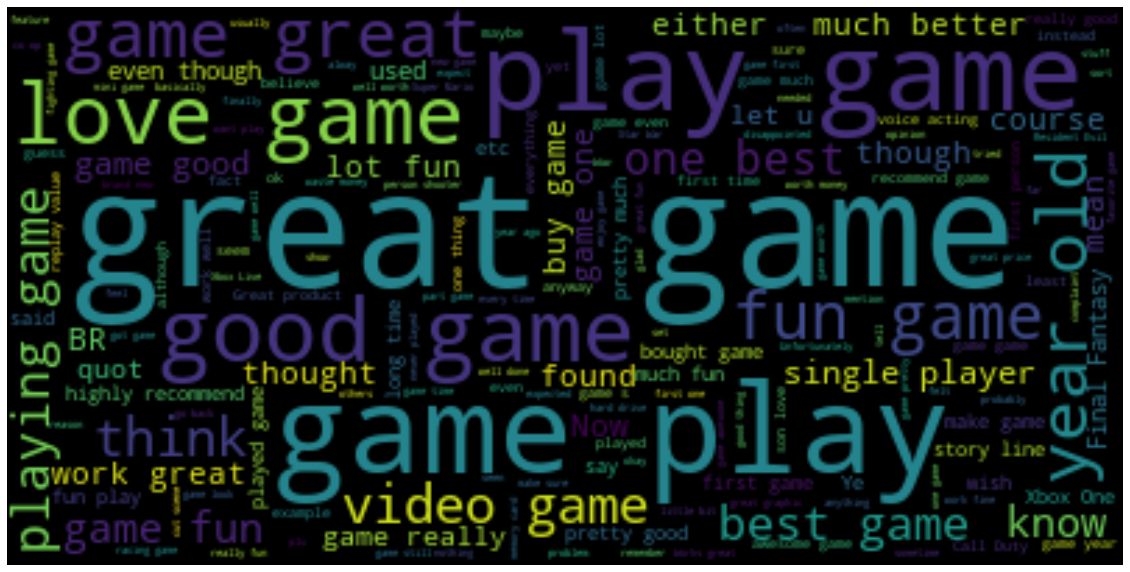

In [36]:
full_text = ' '.join(games.review_clean)
wordcloud = WordCloud().generate(full_text)

plt.rcParams["figure.figsize"] = (20,15)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

This is a word cloud showing word frequency across all reviews. The most frequent words here definitely trend towards the positive side with 'great' showing up frequently, this could be because over 50% of all of the reviews are 5 star reviews, and the vast majority of reviews are positive.

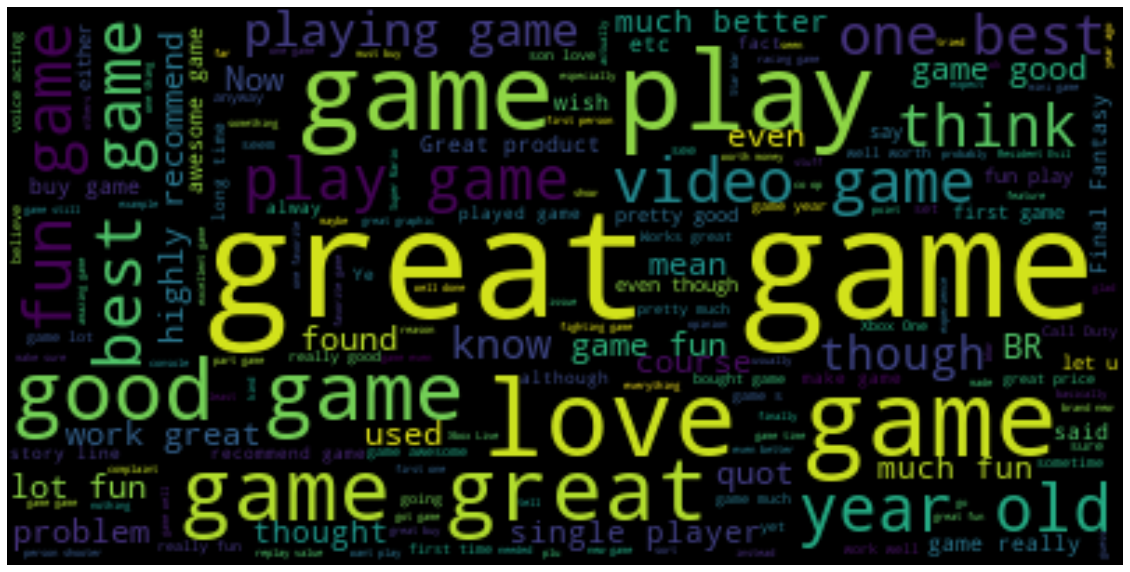

In [37]:
full_text = ' '.join(games.review_clean[games.Sentiment_target=='Positive'])
wordcloud = WordCloud().generate(full_text)

plt.rcParams["figure.figsize"] = (20,15)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

This is a word cloud showing word frequency is positive reviews.It looks very similar tothe word cloud showing all reviews, but words expressing positive sentiment like 'good', 'great', and 'love' are more common. 

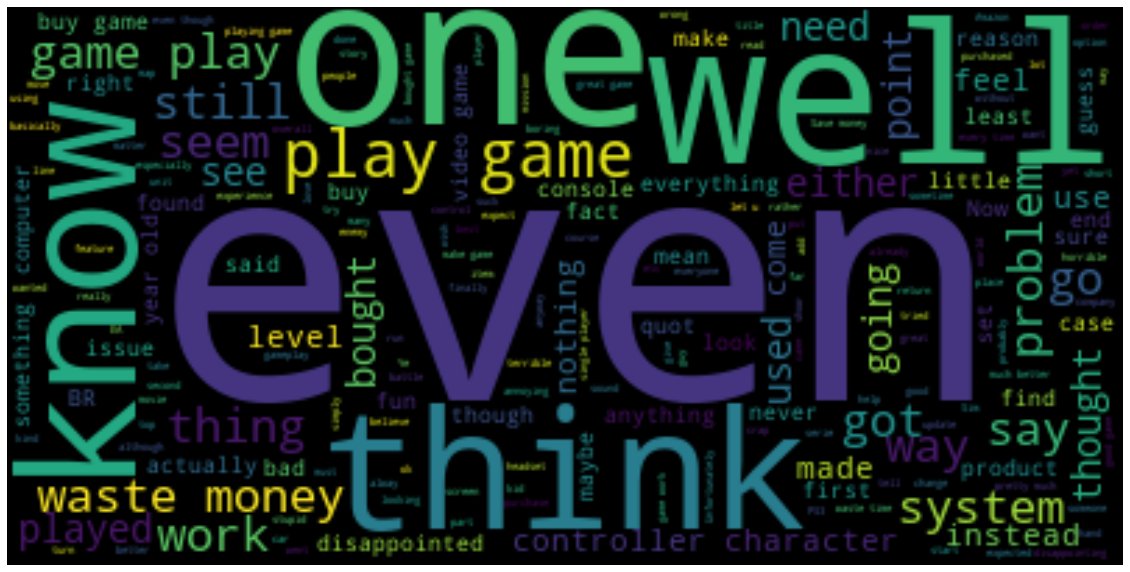

In [38]:
full_text = ' '.join(games.review_clean[games.Sentiment_target=='Negative'])
wordcloud = WordCloud().generate(full_text)

plt.rcParams["figure.figsize"] = (20,15)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Modeling

Grab our review_clean and Sentiment_target columns and rename them as we are going to use these columns to fit our model.

In [40]:
# Sentiment_target review_clean
games = games[['review_clean','Sentiment_target']]
games.columns = ['text', 'sentiment']
games

,text,sentiment
0,amazing joystick I especially love twist ... U...,Positive
1,Definitely silent mouse ... Not single click h...,Positive
2,poor quality work advertised,Negative
3,good could bettee nice tend slip away stick in...,Neutral
4,Great flawed Great amiibo great collecting Qua...,Positive
...,...,...
1780263,quot Riven quot generally life billing I think...,Positive
1780264,An Immersive Experience A Work Art If I could ...,Positive
1780265,Riven Driven Microsoft Fewer 1 3 modern Window...,Negative
1780266,Disappointment Unfortunately Riven available p...,Negative


Create our word embeddings with the 20,000 most frequent words as our input dimension, 128 embedding_size as our output dimension, and maxlen as our max input of 128 words. 

Our convolutional layer has a kernel size of 5, 64 filters, and pool size of 4. Conv1d was designed for sequence analysis. 

We have 70 units for output dimensions on our LSTM layer. 

And finally a batch size of 30 samples is input into the network at once and we will train 2 epochs. 

In [41]:
# Embedding
max_features = 20000
maxlen = 100
embedding_size = 128

# Convolution
kernel_size = 5
filters = 64
pool_size = 4

# LSTM
lstm_output_size = 70

# Training
batch_size = 30
epochs = 2

The keras tokenizer class allows to vectorize a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary) or into a vector where the coefficient for each token could be binary, based on word count, based on tf-idf. By default, all punctuation is removed, turning the texts into space-separated sequences of words (words maybe include the ' character). These sequences are then split into lists of tokens. They will then be indexed or vectorized.

text_to_sequences method transforms each text in texts to a sequence of integers.

pad_sequences adds 0's if they are not of length 100 so the inputs for are model are all of equal length.

In [42]:
games = games[games.sentiment != "Neutral"]
games['text'] = games['text'].apply(lambda x: str(x).lower())
games['text'] = games['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

print(games[ games['sentiment'] == 'Positive'].size)
print(games[ games['sentiment'] == 'Negative'].size)

for idx,row in games.iterrows():
    row[0] = row[0].replace('rt',' ')
    
tokenizer = Tokenizer(nb_words = max_features, split=' ')
tokenizer.fit_on_texts(games['text'].values)
X = tokenizer.texts_to_sequences(games['text'].values)
X = pad_sequences(X, maxlen = maxlen)

2681090
572332


Make our splits with 80% for train and 20% for test

In [43]:
Y = pd.get_dummies(games['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1301368, 100) (1301368, 2)
(325343, 100) (325343, 2)


Define our model architecture as sequential where each layer has one input and one output, a linear model. With 6 layers in total: embedding, dropout, conv1d, max pooling, LSTM, and dense. 

Categorical cross entropy loss function, adam optimizer and accuracy for metrics.

In [44]:
print('Build model...')

model = Sequential()
model.add(Embedding(max_features, embedding_size, input_length=maxlen))
model.add(Dropout(0.25))
model.add(Conv1D(filters, kernel_size, padding='valid', activation='relu', strides=1))
model.add(MaxPooling1D(pool_size=pool_size))
model.add(LSTM(lstm_output_size))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Build model...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 128)          2560000   
_________________________________________________________________
dropout (Dropout)            (None, 100, 128)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 64)            41024     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 24, 64)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 70)                37800     
_________________________________________________________________
dense (Dense)                (None, 2)                 142       
Total params: 2,638,966
Trainable params: 2,638,966
Non-trainable params: 0
_______________________________

Lets train and fit a model!

In [45]:
print('Train...')
model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs,shuffle=True, validation_data=(X_test, Y_test))

Train...
Epoch 1/2
43379/43379 [==============================] - 631s 15ms/step - loss: 0.1491 - accuracy: 0.9428 - val_loss: 0.1329 - val_accuracy: 0.9490
Epoch 2/2
43379/43379 [==============================] - 630s 15ms/step - loss: 0.1253 - accuracy: 0.9529 - val_loss: 0.1285 - val_accuracy: 0.9511


Run predictions on our test set and use the metrics class from sklearn to measure precision, recall, and f1 score

In [46]:
yhat = model.predict(X_test, verbose = 2, batch_size = batch_size)
from sklearn import metrics
print(metrics.classification_report(Y_test[:,1], np.round(yhat[:,1]) ,target_names = ["negative", "positive"]))

10845/10845 - 25s
              precision    recall  f1-score   support

    negative       0.89      0.82      0.86     57226
    positive       0.96      0.98      0.97    268117

    accuracy                           0.95    325343
   macro avg       0.93      0.90      0.91    325343
weighted avg       0.95      0.95      0.95    325343



Save our model json and our model weights as an hdf5 file to disk.

In [48]:
# serialize model to JSON
model_json = model.to_json()
with open("model_conv_lstm.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_conv_lstm.h5")

Create a confusion matrix to compare predictions to actual values in our test data.

In [49]:
score = ['negative', 'positive']

# Compute confusion matrix
cm = confusion_matrix(Y_test[:,1], np.round(yhat[:,1]))
np.set_printoptions(precision=2)

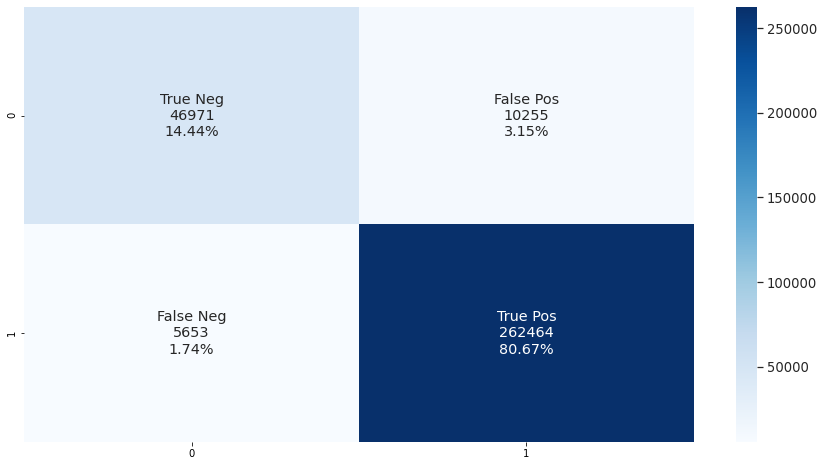

In [50]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.subplots(figsize=(15,8))
sns.set(font_scale=1.2)
conf_plot = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')

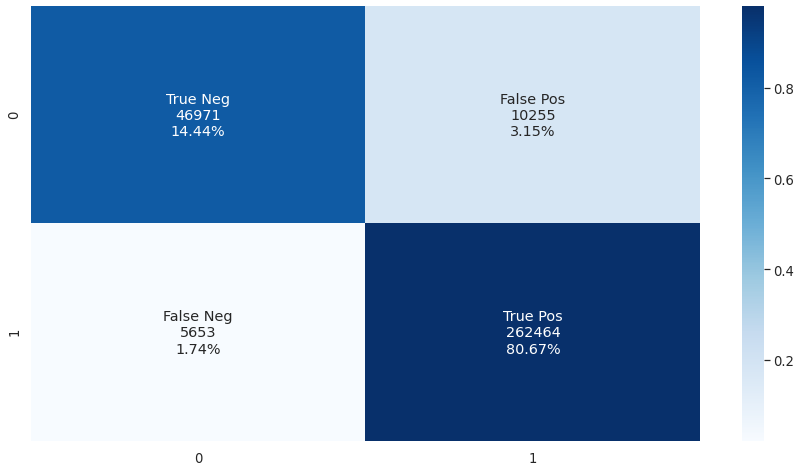

In [51]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.subplots(figsize=(15,8))
sns.set(font_scale=1.2)
conf_plot_norm = sns.heatmap(cm_normalized, annot=labels, fmt='', cmap='Blues')